# セットアップ

## ライブラリのインポート

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import re # 正規表現
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from tqdm import tqdm # for文の進捗状況を見るために使う

In [2]:
plt.style.use("ggplot")
plt.rcParams['font.family'] = "MS Gothic"
plt.rcParams["font.size"] = 20

# データの読み込み

## 訓練データの出力(購入データ)
`train_purchases.csv`：各セッションでの正解ラベル．

In [3]:
path_data = r'C:\Users\yota-\Desktop\study\mystudy\recsys\dressipi_recsys2022\data'
df_train_purchases = pd.read_csv(path_data + r"\train_purchases.csv")
display(df_train_purchases)

,session_id,item_id,date
0,3,15085,2020-12-18 21:26:47.986
1,13,18626,2020-03-13 19:36:15.507
2,18,24911,2020-08-26 19:20:32.049
3,19,12534,2020-11-02 17:16:45.92
4,24,13226,2020-02-26 18:27:44.114
...,...,...,...
999995,4439986,2915,2021-05-13 11:56:37.464
999996,4439990,8786,2020-08-22 14:28:22.382
999997,4439994,21630,2020-11-27 20:10:28.961
999998,4439999,16962,2020-11-27 11:01:41.356


## 訓練データの入力(各セッションでのitemのビュー)
`train_sessions.csv`：各セッションにおいて，購入の直前まで見ていた商品の一覧．

In [4]:
df_train_sessions = pd.read_csv(path_data + r"\train_sessions.csv")
display(df_train_sessions)

,session_id,item_id,date
0,3,9655,2020-12-18 21:25:00.373
1,3,9655,2020-12-18 21:19:48.093
2,13,15654,2020-03-13 19:35:27.136
3,18,18316,2020-08-26 19:18:30.833
4,18,2507,2020-08-26 19:16:31.211
...,...,...,...
4743815,4440001,20409,2020-10-30 23:37:20.658
4743816,4440001,14155,2020-10-30 23:31:56.607
4743817,4440001,14303,2020-10-30 23:36:17.934
4743818,4440001,27852,2020-10-30 23:39:55.186


`df_train_sessions`に，曜日や時間帯の情報を追加．

In [5]:
# 曜日の情報を追加するための準備
w_list = ["Mon", "Tue", "Wed", "Thr", "Fri", "Sat", "Sun"]

# 時間帯の情報を追加するための準備
def hour_to_timezoon(hour):
    if hour < 6.0:
        return "midnight"
    elif hour < 10.0:
        return "morning"
    elif hour < 16.0:
        return "afternoon"
    elif hour < 21.0:
        return "night"
    else:
        return "midnight"
    
# 曜日や時間帯の情報を追加
for idx in tqdm(df_train_sessions.index): # tqdmを外せばプログレスバーなしの表示
    # date列に表記ゆれがあるため，一度正規表現を通して変換する必要あり
    datetime_list = re.findall(r"\d+", df_train_sessions.at[idx, "date"])
    datetime_list = [int(s) for s in datetime_list] # 文字列からintに変換
    df_train_sessions.at[idx, "date_as_datetime"] = datetime.datetime(datetime_list[0], datetime_list[1], datetime_list[2],\
                                                                   datetime_list[3], datetime_list[4]) # datetime型に変換
    df_train_sessions.at[idx, "day_of_week"] = w_list[int(df_train_sessions.at[idx, "date_as_datetime"].weekday())] # 曜日に変換
    df_train_sessions.at[idx, "hour"] = datetime_list[3] # 時間の情報
    df_train_sessions.at[idx, "time_zoon"] = hour_to_timezoon(datetime_list[3]) # 時間の情報

df_train_sessions["day_of_week_and_time_zoon"] = df_train_sessions["day_of_week"] + "-" + df_train_sessions["time_zoon"]
df_train_sessions

100%|██████████████████████████████████████████████████████████████████████| 4743820/4743820 [15:16<00:00, 5174.37it/s]


,session_id,item_id,date,date_as_datetime,day_of_week,hour,time_zoon,day_of_week_and_time_zoon
0,3,9655,2020-12-18 21:25:00.373,2020-12-18 21:25:00,Fri,21.0,midnight,Fri-midnight
1,3,9655,2020-12-18 21:19:48.093,2020-12-18 21:19:00,Fri,21.0,midnight,Fri-midnight
2,13,15654,2020-03-13 19:35:27.136,2020-03-13 19:35:00,Fri,19.0,night,Fri-night
3,18,18316,2020-08-26 19:18:30.833,2020-08-26 19:18:00,Wed,19.0,night,Wed-night
4,18,2507,2020-08-26 19:16:31.211,2020-08-26 19:16:00,Wed,19.0,night,Wed-night
...,...,...,...,...,...,...,...,...
4743815,4440001,20409,2020-10-30 23:37:20.658,2020-10-30 23:37:00,Fri,23.0,midnight,Fri-midnight
4743816,4440001,14155,2020-10-30 23:31:56.607,2020-10-30 23:31:00,Fri,23.0,midnight,Fri-midnight
4743817,4440001,14303,2020-10-30 23:36:17.934,2020-10-30 23:36:00,Fri,23.0,midnight,Fri-midnight
4743818,4440001,27852,2020-10-30 23:39:55.186,2020-10-30 23:39:00,Fri,23.0,midnight,Fri-midnight


In [6]:
df_train_sessions["day_of_week_and_time_zoon"] = df_train_sessions["day_of_week"] + "-" + df_train_sessions["time_zoon"]
df_train_sessions

,session_id,item_id,date,date_as_datetime,day_of_week,hour,time_zoon,day_of_week_and_time_zoon
0,3,9655,2020-12-18 21:25:00.373,2020-12-18 21:25:00,Fri,21.0,midnight,Fri-midnight
1,3,9655,2020-12-18 21:19:48.093,2020-12-18 21:19:00,Fri,21.0,midnight,Fri-midnight
2,13,15654,2020-03-13 19:35:27.136,2020-03-13 19:35:00,Fri,19.0,night,Fri-night
3,18,18316,2020-08-26 19:18:30.833,2020-08-26 19:18:00,Wed,19.0,night,Wed-night
4,18,2507,2020-08-26 19:16:31.211,2020-08-26 19:16:00,Wed,19.0,night,Wed-night
...,...,...,...,...,...,...,...,...
4743815,4440001,20409,2020-10-30 23:37:20.658,2020-10-30 23:37:00,Fri,23.0,midnight,Fri-midnight
4743816,4440001,14155,2020-10-30 23:31:56.607,2020-10-30 23:31:00,Fri,23.0,midnight,Fri-midnight
4743817,4440001,14303,2020-10-30 23:36:17.934,2020-10-30 23:36:00,Fri,23.0,midnight,Fri-midnight
4743818,4440001,27852,2020-10-30 23:39:55.186,2020-10-30 23:39:00,Fri,23.0,midnight,Fri-midnight


## 特徴量データ
`df_item_features`：各itemの特徴量を表すテーブル．
`feature_category_id`と`feature_value_id`をセットにした`feature_category_and_value_id`を作成する．

In [7]:
df_item_features = pd.read_csv(path_data + r"\item_features.csv")
# カテゴリと値をセットにした列を追加
df_item_features["feature_category_and_value"] = \
        df_item_features["feature_category_id"].astype("str") + "-" + df_item_features["feature_value_id"].astype("str")
display(df_item_features)

,item_id,feature_category_id,feature_value_id,feature_category_and_value
0,2,56,365,56-365
1,2,62,801,62-801
2,2,68,351,68-351
3,2,33,802,33-802
4,2,72,75,72-75
...,...,...,...,...
471746,28143,68,351,68-351
471747,28143,55,390,55-390
471748,28143,11,109,11-109
471749,28143,73,91,73-91


`feature_category_and_value_id`に関して，pivotを用いつつ共起行列を生成する．

In [8]:
# pivotで共起行列を生成
df_item_features_pivot = df_item_features.pivot_table(values = "feature_value_id", index = "item_id", columns = "feature_category_and_value", aggfunc = "count")
df_item_features_pivot.fillna(0.0, inplace = True) # 標準化のためnaを0で埋める
display(df_item_features_pivot)

feature_category_and_value,1-143,1-358,1-461,1-517,1-60,1-771,10-147,10-159,10-184,10-217,...,73-544,73-91,8-157,8-323,8-420,8-636,9-175,9-178,9-190,9-369
item_id,,,,,,,,,,,,,,,,,,,,,
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28139,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28140,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28141,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


購入前のビューについて，`day_of_week_and_time_zoon`についての共起行列を生成．

In [9]:
df_item_time_pivot = df_train_sessions.pivot_table(values = "session_id", index = "item_id", columns = "day_of_week_and_time_zoon", aggfunc = "count")
df_item_time_pivot.fillna(0.0, inplace = True)

df_item_time_pivot = df_item_time_pivot.apply(lambda x: np.log(1 + np.log(1 + x))) # 外れ値が多いため，2重でlogをとる

display(df_item_time_pivot)

day_of_week_and_time_zoon,Fri-afternoon,Fri-midnight,Fri-morning,Fri-night,Mon-afternoon,Mon-midnight,Mon-morning,Mon-night,Sat-afternoon,Sat-midnight,...,Thr-morning,Thr-night,Tue-afternoon,Tue-midnight,Tue-morning,Tue-night,Wed-afternoon,Wed-midnight,Wed-morning,Wed-night
item_id,,,,,,,,,,,,,,,,,,,,,
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,1.194706,0.741276,0.869742,1.162283,1.080418,1.080418,0.959135,1.124748,1.327761,1.194706,...,1.194706,1.026672,1.026672,1.162283,0.869742,1.080418,0.959135,0.869742,0.869742,0.959135
4,1.385227,1.124748,1.223156,1.397363,1.419607,1.291725,1.162283,1.448822,1.457646,0.869742,...,0.526589,1.397363,1.271150,1.162283,1.372307,1.310506,1.310506,1.080418,1.310506,1.327761
8,1.080418,1.223156,1.194706,0.959135,1.162283,0.869742,0.000000,0.959135,1.080418,0.959135,...,1.026672,1.080418,1.026672,0.869742,0.526589,1.080418,0.741276,0.869742,0.526589,0.741276
9,1.026672,0.000000,0.000000,0.000000,0.526589,0.000000,0.000000,0.526589,0.526589,0.000000,...,0.526589,0.000000,0.000000,0.000000,0.000000,0.526589,0.000000,0.000000,0.000000,0.526589
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28139,1.291725,1.080418,1.248441,1.343703,1.327761,1.080418,1.162283,1.248441,1.327761,1.162283,...,1.194706,1.310506,1.419607,1.162283,0.869742,1.466077,1.223156,0.526589,1.162283,1.291725
28140,1.607232,1.429846,1.310506,1.466077,1.327761,1.194706,1.358505,1.124748,1.343703,1.419607,...,1.080418,1.474144,1.248441,1.310506,1.026672,1.419607,1.162283,1.291725,0.959135,1.248441
28141,1.080418,1.026672,0.869742,1.026672,1.194706,0.869742,0.741276,1.162283,1.194706,1.026672,...,0.741276,1.080418,1.248441,1.194706,1.194706,0.959135,1.026672,1.026672,0.869742,0.526589


特徴量のテーブル`df_item_features_pivot`に，`day_of_week_and_time_zoon`の情報をjoinする．

In [10]:
df_item_features_pivot = pd.merge(df_item_features_pivot, df_item_time_pivot, on = "item_id", how = "left")
df_item_features_pivot.fillna(0.0, inplace = True) # joinができないitemや購入が発生していない時間についてはNaNが生じるため，埋める
display(df_item_features_pivot)

,1-143,1-358,1-461,1-517,1-60,1-771,10-147,10-159,10-184,10-217,...,Thr-morning,Thr-night,Tue-afternoon,Tue-midnight,Tue-morning,Tue-night,Wed-afternoon,Wed-midnight,Wed-morning,Wed-night
item_id,,,,,,,,,,,,,,,,,,,,,
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.194706,1.026672,1.026672,1.162283,0.869742,1.080418,0.959135,0.869742,0.869742,0.959135
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.526589,1.397363,1.271150,1.162283,1.372307,1.310506,1.310506,1.080418,1.310506,1.327761
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.026672,1.080418,1.026672,0.869742,0.526589,1.080418,0.741276,0.869742,0.526589,0.741276
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28139,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.194706,1.310506,1.419607,1.162283,0.869742,1.466077,1.223156,0.526589,1.162283,1.291725
28140,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.080418,1.474144,1.248441,1.310506,1.026672,1.419607,1.162283,1.291725,0.959135,1.248441
28141,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.741276,1.080418,1.248441,1.194706,1.194706,0.959135,1.026672,1.026672,0.869742,0.526589


## 特徴量ベクトルの共起行列に対してPCA
すべてのitemに0が入るような特徴量はないらしい．

In [11]:
df_item_features_pca = df_item_features_pivot.apply(lambda x:  (x - x.mean()) / x.std(), axis = 0) # PCAのため，各列のデータを標準化(自動で標準化してほしい)
print("==============すべてのitemに対し，0が入っているのはこの特徴量たち==============")
display(df_item_features_pca.loc[:,df_item_features_pca.isnull().any()]) # すべてのitemに対し0であるような列の場所を確認
df_item_features_pca.fillna(0.0, inplace = True) # すべてのitemに対し0であるような列は標準化がうまくいかずNaNが生じるため，このタイミングで再度fillnaする必要あり

# 主成分分析
pca = PCA()
pca.fit(df_item_features_pca)
feature = pca.transform(df_item_features_pca)
print("==============すべての商品に対しPCAした結果は以下==============")
df_item_features_pca = pd.DataFrame(feature, columns = ["PC{}".format(x + 1) for x in range(len(df_item_features_pca.columns))], index = df_item_features_pivot.index)
display(df_item_features_pca)

==============すべてのitemに対し，0が入っているのはこの特徴量たち==============


""
item_id
2
3
4
7
8
...
28139
28140
28141


==============すべての商品に対しPCAした結果は以下==============


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC923,PC924,PC925,PC926,PC927,PC928,PC929,PC930,PC931,PC932
item_id,,,,,,,,,,,,,,,,,,,,,
2,-7.102405,0.211415,6.450031,0.662417,-1.853176,1.903691,-2.668837,0.388453,-1.553214,-0.140735,...,-8.534840e-16,-1.408595e-15,1.290634e-15,2.723516e-15,-2.775558e-16,-2.331468e-15,-1.949829e-15,3.982925e-15,7.979728e-17,-1.575129e-15
3,4.024329,-2.085267,-2.601140,-0.355224,-0.957370,-0.502587,0.038208,-0.494711,-1.550502,-0.449726,...,-2.671474e-16,7.285839e-17,7.806256e-16,-2.588207e-15,3.330669e-16,1.422473e-15,2.407796e-15,-8.326673e-17,1.523087e-15,-3.070461e-16
4,6.200300,-1.646001,-2.339591,1.812499,-3.912525,0.038175,0.523519,0.128563,0.403339,-0.429581,...,-3.122502e-17,1.026956e-15,-3.157197e-16,-1.144917e-16,-6.938894e-16,9.714451e-17,-9.020562e-16,2.081668e-16,-5.828671e-16,-9.749146e-16
7,-7.293682,-2.214886,-0.013985,-1.327609,1.873806,1.168581,0.728220,1.165480,-2.716180,0.658455,...,2.386980e-15,9.742207e-15,1.772887e-15,6.501744e-15,-2.220446e-15,1.706968e-15,1.595946e-16,-3.899658e-15,-7.355228e-16,-4.701101e-16
8,3.255347,-2.036499,-1.959593,-0.000560,-2.236343,-0.791030,-2.274492,-0.744740,0.771452,-0.363599,...,1.686151e-15,1.651457e-15,8.534840e-16,-6.140921e-16,-5.551115e-17,-7.563394e-16,-4.093947e-16,9.436896e-16,5.793976e-16,-4.822531e-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28139,5.836899,-1.201876,-1.336478,-2.242177,0.363416,0.031448,-0.335812,0.611717,-1.356771,0.464384,...,-3.191891e-16,3.313322e-15,-2.480655e-15,-4.642120e-15,2.498002e-16,-1.734723e-15,1.207368e-15,-4.024558e-16,-1.665335e-16,-1.863093e-15
28140,4.035380,10.785641,-2.962123,0.338891,1.072837,2.003313,0.803218,-5.084167,-0.980142,-1.415587,...,1.831868e-15,-1.797174e-15,-1.526557e-15,-1.221245e-15,5.551115e-16,0.000000e+00,1.776357e-15,-2.220446e-16,1.998401e-15,-7.598089e-16
28141,3.422522,-1.753701,-2.383617,2.941787,-2.507803,3.986431,2.566447,1.171138,2.230209,0.338236,...,-1.977585e-15,-3.712308e-16,1.942890e-15,1.838807e-15,1.498801e-15,3.427814e-15,2.046974e-15,2.053913e-15,-1.609823e-15,1.495332e-15


PCAした空間で，itemの散布図を表示する．このPCAはitemの特徴量と時間の情報を含んでいる．

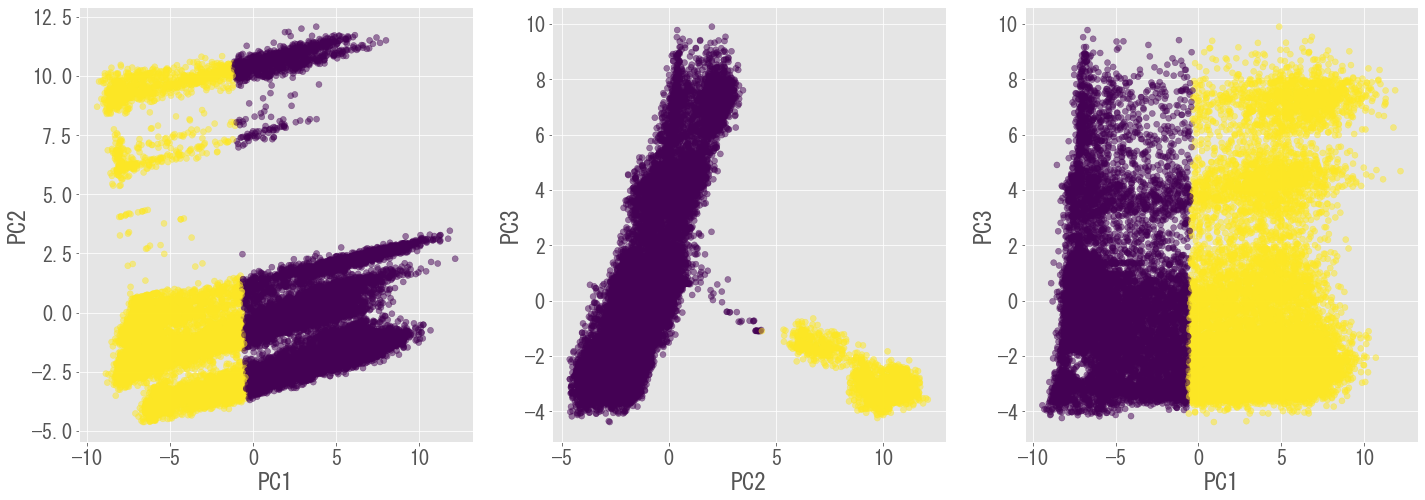

In [12]:
pca_pair_list = [["PC1", "PC2"], ["PC2", "PC3"], ["PC1", "PC3"]]

fig = plt.figure(figsize = (24, 8))

for idx, pair in enumerate(pca_pair_list):
    pred = KMeans(n_clusters = 2).fit_predict(df_item_features_pca[pair].values) # 2次元に落とした結果をクラスタリング．
    ax = fig.add_subplot(1, len(pca_pair_list), idx + 1)
    pca_x, pca_y = pair # x軸とy軸
    ax.scatter(df_item_features_pca[pca_x], df_item_features_pca[pca_y], alpha = 0.5, c = pred)
    ax.set_xlabel(pca_x)
    ax.set_ylabel(pca_y)

特徴量と主成分の関係を図示する．`df_pca_components`は，特徴量の空間で主成分ベクトルを表示したもの．
ここから，主成分に各特徴量がどのように効いているのかも見ることができる．
時間に関する特徴量は，他の特徴量と離れた位置にあることが確認できる．一方で，時間の情報は固まってしまっているため，あまり意味がある情報ではないのかも．

,1-143,1-358,1-461,1-517,1-60,1-771,10-147,10-159,10-184,10-217,...,Thr-morning,Thr-night,Tue-afternoon,Tue-midnight,Tue-morning,Tue-night,Wed-afternoon,Wed-midnight,Wed-morning,Wed-night
PC1,-0.000272,-1.795978e-03,8.224175e-03,-1.105725e-04,1.020850e-04,-2.567457e-03,0.002177,-0.005095,0.000017,-0.007404,...,1.659963e-01,1.748491e-01,1.772650e-01,1.710041e-01,1.682530e-01,1.779428e-01,1.736664e-01,1.682556e-01,1.627958e-01,1.747525e-01
PC2,-0.004096,-1.115176e-03,-2.639834e-02,-5.989581e-04,-2.607602e-04,-1.632201e-03,-0.005802,-0.012052,-0.001184,-0.007207,...,3.352070e-02,2.917555e-02,2.930507e-02,2.681164e-02,2.833510e-02,2.791262e-02,3.057090e-02,2.807652e-02,3.120617e-02,3.031191e-02
PC3,-0.005202,-1.879730e-04,-3.806292e-02,-1.184780e-03,-4.053209e-04,-2.922017e-04,-0.004747,-0.001849,-0.001118,-0.003629,...,2.975982e-03,-2.816051e-04,-2.305711e-03,3.749566e-03,2.880621e-03,-4.033321e-03,5.324770e-03,8.730717e-03,1.145779e-02,-1.234652e-03
PC4,0.009275,1.204656e-03,9.714243e-02,3.000732e-03,2.376430e-03,4.365858e-03,0.027499,0.067001,0.007241,0.019171,...,-1.048077e-03,-8.540048e-03,-3.668909e-03,2.601015e-03,-3.833996e-04,-5.542340e-03,-7.267046e-04,3.465816e-03,6.550310e-04,-5.577944e-03
PC5,-0.009938,-2.585991e-03,-1.086604e-01,-2.831877e-03,-2.121227e-03,-4.340889e-03,0.006123,0.032712,0.003469,0.021834,...,3.080303e-02,2.172092e-02,1.016592e-02,1.521649e-02,1.604057e-02,9.524558e-03,2.142365e-02,2.329549e-02,2.900305e-02,1.794875e-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PC928,-0.000000,-1.350038e-16,-1.287948e-16,-8.373194e-17,-1.478256e-16,-2.275020e-18,-0.001552,-0.003631,-0.000431,-0.001748,...,-1.395910e-17,4.317158e-17,-2.466467e-16,6.373754e-17,-3.821813e-18,-7.274997e-17,-1.132449e-16,4.679688e-17,7.768309e-17,4.821989e-17
PC929,-0.000000,5.819424e-17,5.824357e-18,-8.661092e-17,-3.194543e-17,4.424020e-17,0.000365,0.000855,0.000101,0.000411,...,1.172463e-17,1.691914e-16,2.691638e-17,-1.060587e-16,-3.619541e-17,-2.511283e-17,-8.382238e-18,9.851671e-17,-1.647987e-17,4.063217e-17
PC930,-0.000000,-1.774430e-16,3.246650e-17,-6.122426e-19,6.952374e-19,-8.157446e-17,0.001483,0.003469,0.000411,0.001670,...,4.121324e-17,9.450177e-17,6.423856e-17,-6.017322e-18,1.311885e-17,-3.458605e-17,-1.469094e-17,-1.081424e-16,3.997996e-17,-2.578368e-17
PC931,0.000000,-1.170670e-16,-1.865200e-16,-8.147640e-17,-2.685936e-18,-8.003258e-17,-0.000430,-0.001006,-0.000119,-0.000485,...,4.883653e-17,-1.210834e-16,-7.467824e-17,-1.687730e-16,8.117964e-18,-2.694242e-17,-1.836367e-17,3.408461e-18,1.068617e-17,-3.767433e-17


Text(0, 0.5, 'PC2')

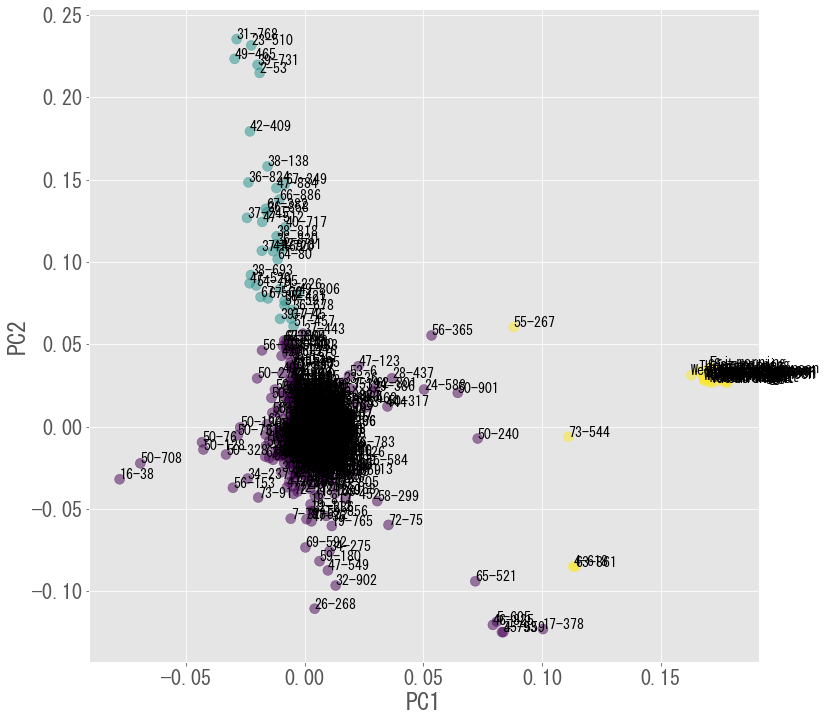

In [13]:
# 特徴量の空間で主成分ベクトルを表示
df_pca_components = pd.DataFrame(pca.components_, index = ["PC{}".format(x + 1) for x in range(len(df_item_features_pca.columns))], columns = df_item_features_pivot.columns)
display(df_pca_components)

# 2次元に落とした結果をクラスタリング．
pred = KMeans(n_clusters = 3).fit_predict(pca.components_[[0,1]].T)
ax = plt.figure(figsize = (12, 12)).add_subplot(1, 1, 1)

# 第一主成分と第二主成分における観測変数の寄与度をプロットする
for x, y, name in zip(pca.components_[0], pca.components_[1], df_item_features_pivot.columns.values):
    ax.text(x, y, name, fontsize = 14)
ax.scatter(pca.components_[0], pca.components_[1], alpha=0.5, c = pred, s = 100.0)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")

`PC1`が$0.15$を超えているような特徴量を列挙する．すべて時間になっている．

In [14]:
df_pca_components.T[df_pca_components.T["PC1"] > 0.15].index

Index(['Fri-afternoon', 'Fri-midnight', 'Fri-morning', 'Fri-night',
       'Mon-afternoon', 'Mon-midnight', 'Mon-morning', 'Mon-night',
       'Sat-afternoon', 'Sat-midnight', 'Sat-morning', 'Sat-night',
       'Sun-afternoon', 'Sun-midnight', 'Sun-morning', 'Sun-night',
       'Thr-afternoon', 'Thr-midnight', 'Thr-morning', 'Thr-night',
       'Tue-afternoon', 'Tue-midnight', 'Tue-morning', 'Tue-night',
       'Wed-afternoon', 'Wed-midnight', 'Wed-morning', 'Wed-night'],
      dtype='object')

# モデルの作成

`df_test_leaderboard`：テストデータの入力．

In [15]:
num_prediction_list = 100 # 100位までを出力
df_test_leaderboard = pd.read_csv(path_data + r"\test_leaderboard_sessions.csv")
display(df_test_leaderboard)

,session_id,item_id,date
0,26,19185,2021-06-16 09:53:54.158
1,200,17089,2021-06-25 12:23:40.811
2,200,17089,2021-06-25 12:24:36.631
3,200,8060,2021-06-25 12:24:41.677
4,200,4758,2021-06-25 12:24:50.692
...,...,...,...
229349,4439653,25955,2021-06-11 10:22:57.47
229350,4439653,12179,2021-06-11 10:23:00.663
229351,4439757,2078,2021-06-30 11:42:15.073
229352,4439757,2078,2021-06-30 11:43:13.725


主成分空間上での距離に基づいてpredictionする．(40分くらいかかる)

In [16]:
# 候補がこれしかないの知らなかった．．．
df_candidate_items = pd.read_csv(path_data + r"\candidate_items.csv")
display(df_candidate_items)

,item_id
0,4
1,8
2,9
3,19
4,20
...,...
4985,28128
4986,28131
4987,28132
4988,28133


In [17]:
df_candidate_items_pca = pd.merge(df_candidate_items, df_item_features_pca, on = "item_id", how = "left")
display(df_candidate_items_pca)

,item_id,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC923,PC924,PC925,PC926,PC927,PC928,PC929,PC930,PC931,PC932
0,4,6.200300,-1.646001,-2.339591,1.812499,-3.912525,0.038175,0.523519,0.128563,0.403339,...,-3.122502e-17,1.026956e-15,-3.157197e-16,-1.144917e-16,-6.938894e-16,9.714451e-17,-9.020562e-16,2.081668e-16,-5.828671e-16,-9.749146e-16
1,8,3.255347,-2.036499,-1.959593,-0.000560,-2.236343,-0.791030,-2.274492,-0.744740,0.771452,...,1.686151e-15,1.651457e-15,8.534840e-16,-6.140921e-16,-5.551115e-17,-7.563394e-16,-4.093947e-16,9.436896e-16,5.793976e-16,-4.822531e-16
2,9,-3.680840,-3.662167,-3.015864,-0.449000,-5.150689,-2.977280,-0.326546,-1.979427,-1.729696,...,2.393918e-16,-1.002670e-15,-1.450229e-15,-1.259409e-15,-1.776357e-15,-2.414735e-15,1.422473e-15,1.235123e-15,1.332268e-15,8.291978e-16
3,19,4.405898,0.815198,4.656818,-0.389904,-0.015752,-3.543213,2.356771,-0.447817,2.395683,...,1.942890e-16,1.144917e-16,-4.024558e-16,6.661338e-16,-8.326673e-16,-9.228729e-16,2.081668e-16,8.326673e-16,-7.771561e-16,-4.007211e-16
4,20,5.262356,-1.790380,-2.695701,4.302209,-2.920747,5.343836,4.124741,2.129953,3.699506,...,7.771561e-16,-5.412337e-16,6.869505e-16,1.873501e-16,8.881784e-16,7.216450e-16,-6.869505e-16,-4.163336e-16,-6.279699e-16,-2.203099e-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4985,28128,3.618828,-1.909964,-1.326241,-1.967633,-2.747479,-0.664341,-5.222040,-1.120702,3.335453,...,5.308254e-16,-8.743006e-16,-1.536965e-15,-1.137979e-15,5.551115e-17,-5.620504e-16,1.137979e-15,3.747003e-16,-6.071532e-16,-5.169476e-16
4986,28131,1.077043,-0.734710,0.561595,-2.652704,2.649252,-1.665728,3.517474,0.502433,-1.589187,...,-1.058181e-15,-7.337880e-15,2.994133e-15,5.932754e-16,2.775558e-16,-6.036838e-16,-1.498801e-15,1.526557e-16,-5.898060e-17,-1.458902e-15
4987,28132,0.519853,10.741923,-2.937287,0.101659,0.004033,-0.421703,-1.091104,0.411428,1.329393,...,4.475587e-16,6.772360e-15,3.837208e-15,3.434752e-16,-4.996004e-16,4.753142e-15,-1.880440e-15,-2.400857e-15,5.828671e-15,4.336809e-16
4988,28133,8.697073,2.570241,8.481825,0.680943,-0.644097,2.759894,-1.991562,0.989665,-2.023896,...,-1.460637e-15,3.077399e-15,-4.975187e-15,2.678413e-15,-2.498002e-16,-3.150258e-15,1.200429e-15,-3.330669e-16,2.178813e-15,-5.731526e-15


In [19]:
df_candidate_items_pca.set_index("item_id", inplace = True)
display(df_candidate_items_pca)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC923,PC924,PC925,PC926,PC927,PC928,PC929,PC930,PC931,PC932
item_id,,,,,,,,,,,,,,,,,,,,,
4,6.200300,-1.646001,-2.339591,1.812499,-3.912525,0.038175,0.523519,0.128563,0.403339,-0.429581,...,-3.122502e-17,1.026956e-15,-3.157197e-16,-1.144917e-16,-6.938894e-16,9.714451e-17,-9.020562e-16,2.081668e-16,-5.828671e-16,-9.749146e-16
8,3.255347,-2.036499,-1.959593,-0.000560,-2.236343,-0.791030,-2.274492,-0.744740,0.771452,-0.363599,...,1.686151e-15,1.651457e-15,8.534840e-16,-6.140921e-16,-5.551115e-17,-7.563394e-16,-4.093947e-16,9.436896e-16,5.793976e-16,-4.822531e-16
9,-3.680840,-3.662167,-3.015864,-0.449000,-5.150689,-2.977280,-0.326546,-1.979427,-1.729696,-0.285865,...,2.393918e-16,-1.002670e-15,-1.450229e-15,-1.259409e-15,-1.776357e-15,-2.414735e-15,1.422473e-15,1.235123e-15,1.332268e-15,8.291978e-16
19,4.405898,0.815198,4.656818,-0.389904,-0.015752,-3.543213,2.356771,-0.447817,2.395683,-3.641179,...,1.942890e-16,1.144917e-16,-4.024558e-16,6.661338e-16,-8.326673e-16,-9.228729e-16,2.081668e-16,8.326673e-16,-7.771561e-16,-4.007211e-16
20,5.262356,-1.790380,-2.695701,4.302209,-2.920747,5.343836,4.124741,2.129953,3.699506,0.280260,...,7.771561e-16,-5.412337e-16,6.869505e-16,1.873501e-16,8.881784e-16,7.216450e-16,-6.869505e-16,-4.163336e-16,-6.279699e-16,-2.203099e-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28128,3.618828,-1.909964,-1.326241,-1.967633,-2.747479,-0.664341,-5.222040,-1.120702,3.335453,-0.202671,...,5.308254e-16,-8.743006e-16,-1.536965e-15,-1.137979e-15,5.551115e-17,-5.620504e-16,1.137979e-15,3.747003e-16,-6.071532e-16,-5.169476e-16
28131,1.077043,-0.734710,0.561595,-2.652704,2.649252,-1.665728,3.517474,0.502433,-1.589187,-0.940714,...,-1.058181e-15,-7.337880e-15,2.994133e-15,5.932754e-16,2.775558e-16,-6.036838e-16,-1.498801e-15,1.526557e-16,-5.898060e-17,-1.458902e-15
28132,0.519853,10.741923,-2.937287,0.101659,0.004033,-0.421703,-1.091104,0.411428,1.329393,1.076662,...,4.475587e-16,6.772360e-15,3.837208e-15,3.434752e-16,-4.996004e-16,4.753142e-15,-1.880440e-15,-2.400857e-15,5.828671e-15,4.336809e-16


In [21]:
df_candidate_items_pca_reduction = df_candidate_items_pca.iloc[:, 0:pca_dimension]

主成分の空間上で，近いものをリストアップする．

In [37]:
# 主成分空間上での距離を定義し，近いものをリストアップする関数
def search_nearest_neighborhood_by_pca(item_id_list, df_item_features_pca, num_prediction_list = 100):
    # 主成分空間で，直近のものについて大きい重みを与えつつ加重平均
    weight = np.arange(1, len(item_id_list)+1, 1)
    weight = weight / sum(weight)
    mean_vec = df_item_features_pca.loc[item_id_list].T.dot(weight).values
    
    # lambda式よりもこちらの方が圧倒的に速い．
    df_item_features_pca_minus_mean = df_candidate_items_pca_reduction - mean_vec # 主成分空間において，どれだけ離れているかを計算
    df_item_features_pca_distance = df_item_features_pca_minus_mean * df_item_features_pca_minus_mean # 各成分を二乗
    # 主成分について和をとることで，二乗距離を計算．ついでにソート．
    df_item_features_pca_distance = df_item_features_pca_distance.sum(axis = 1).to_frame().sort_values(by = 0, ascending = True)
    index_to_drop = df_item_features_pca_distance.index.isin(item_id_list)
    df_item_features_pca_distance = df_item_features_pca_distance[~index_to_drop]
    # df_item_features_pca_distance.drop(index = item_id_list, inplace = True) # viewに入っているものは答えにならないはずなので，dropしておく
    return df_item_features_pca_distance[0: num_prediction_list].index.values


# 主成分空間上の距離に基づいてpredictionする
def predict_by_pca(df_test, df_item_features_pca, pca_dimension = len(df_item_features_pca.columns)):
    session_id_list = df_test["session_id"].unique() # テストデータのsessionについて，ユニークな値を抽出
    
    # predictionのための空のデータフレームを用意
    df_pred = pd.DataFrame(columns = ["session_id", "item_id", "rank"], index = range(len(session_id_list)*num_prediction_list))
    df_pred["session_id"] = np.repeat(session_id_list, num_prediction_list, axis = 0) # session_idは先に埋める
    df_pred["rank"] = np.tile(range(1, num_prediction_list+1), len(session_id_list)) # rankも埋める
    item_id_values = np.zeros(len(df_pred)) # pandasのlocで埋めると時間がかかるので，ndarrayに予測ラベルを埋めていく
    
    # 進捗状況を表示するためのあれこれ(tqdmは関数内ではうまく使えなさそう)
    time_start = datetime.datetime.now()
    idx_step = 100
    
    for idx, session_id in enumerate(session_id_list):
        # 進捗状況を表示
        if idx % idx_step == 1:
            time_now = datetime.datetime.now()
            time_end_expected = time_start + (time_now - time_start) * (len(session_id_list) / idx)
            print("終了時刻(予測):", time_end_expected.strftime("%H:%M:%S"), \
                  ",  進捗：", idx, "/", len(session_id_list), "({:.2%})".format(idx/len(session_id_list)), end = "\r")
        # このセッションについて，ビューに含まれるitemのリストを取得
        item_id_list = df_test[df_test["session_id"] == session_id]["item_id"].values
        # PCAした空間から，予測したリストを取得
        pred_list = search_nearest_neighborhood_by_pca(item_id_list, df_item_features_pca.iloc[:, 0:pca_dimension])
        item_id_values[idx*num_prediction_list: (idx+1)*num_prediction_list] = np.array(pred_list) # pandasのlocで埋めると時間がかかるため，ndarrayを使う
    
    print("経過時間(実績)　=", time_now - time_start, "\n") 
    df_pred["item_id"] = item_id_values # 一気に埋める
    df_pred["item_id"] = df_pred["item_id"].astype("int")
    return df_pred

pca_dimension = 100 # PCAした空間でどこまで次元を用いるかを指定する
df_submit = predict_by_pca(df_test_leaderboard, df_item_features_pca, pca_dimension = pca_dimension)

path_submit = r'C:\Users\yota-\Desktop\study\mystudy\recsys\dressipi_recsys2022\submits'
df_submit.to_csv(path_submit + r"\nearest_neighborhood_by_pca_w_time_weighted.csv", index = False)

経過時間(実績)　= 0:10:28.476253 49901 / 50000 (99.80%)



In [38]:
df_submit

,session_id,item_id,rank
0,26,3260,1
1,26,16411,2
2,26,7109,3
3,26,1937,4
4,26,22166,5
...,...,...,...
4999995,4439757,502,96
4999996,4439757,21456,97
4999997,4439757,15177,98
4999998,4439757,12367,99


`df_candidate_items_pca`を知らなかったときの実装(念のため保存)

In [109]:
# 主成分空間上での距離を定義し，近いものをリストアップする関数
def search_nearest_neighborhood_by_pca(item_id_list, df_item_features_pca, num_prediction_list = 100):
    #mean_vec = df_item_features_pca.loc[item_id_list].mean(axis = 0).values # ビューに含まれる各itemについて，主成分空間の座標の重心を計算
    # 主成分空間で，直近のものについて大きい重みを与えつつ加重平均
    weight = np.arange(1, len(item_id_list)+1, 1)
    weight = weight / sum(weight)
    mean_vec = df_item_features_pca.loc[item_id_list].T.dot(weight).values
    
    # lambda式よりもこちらの方が圧倒的に速い．
    df_item_features_pca_minus_mean = df_item_features_pca - mean_vec # 主成分空間において，どれだけ離れているかを計算
    df_item_features_pca_distance = df_item_features_pca_minus_mean * df_item_features_pca_minus_mean # 各成分を二乗
    # 主成分について和をとることで，二乗距離を計算．ついでにソート．
    df_item_features_pca_distance = df_item_features_pca_distance.sum(axis = 1).to_frame().sort_values(by = 0, ascending = True)
    df_item_features_pca_distance.drop(index = item_id_list, inplace = True) # viewに入っているものは答えにならないはずなので，dropしておく
    return df_item_features_pca_distance[0: num_prediction_list].index.values


# 主成分空間上の距離に基づいてpredictionする
def predict_by_pca(df_test, df_item_features_pca, pca_dimension = len(df_item_features_pca.columns)):
    session_id_list = df_test["session_id"].unique() # テストデータのsessionについて，ユニークな値を抽出
    
    # predictionのための空のデータフレームを用意
    df_pred = pd.DataFrame(columns = ["session_id", "item_id", "rank"], index = range(len(session_id_list)*num_prediction_list))
    df_pred["session_id"] = np.repeat(session_id_list, num_prediction_list, axis = 0) # session_idは先に埋める
    df_pred["rank"] = np.tile(range(1, num_prediction_list+1), len(session_id_list)) # rankも埋める
    item_id_values = np.zeros(len(df_pred)) # pandasのlocで埋めると時間がかかるので，ndarrayに予測ラベルを埋めていく
    
    # 進捗状況を表示するためのあれこれ(tqdmは関数内ではうまく使えなさそう)
    time_start = datetime.datetime.now()
    idx_step = 10
    
    for idx, session_id in enumerate(session_id_list):
        # 進捗状況を表示
        if idx % idx_step == 1:
            time_now = datetime.datetime.now()
            time_end_expected = time_start + (time_now - time_start) * (len(session_id_list) / idx)
            print("終了時刻(予測):", time_end_expected.strftime("%H:%M:%S"), \
                  ",  進捗：", idx, "/", len(session_id_list), "({:.2%})".format(idx/len(session_id_list)), end = "\r")
        # このセッションについて，ビューに含まれるitemのリストを取得
        item_id_list = df_test[df_test["session_id"] == session_id]["item_id"].values
        # PCAした空間から，予測したリストを取得
        pred_list = search_nearest_neighborhood_by_pca(item_id_list, df_item_features_pca.iloc[:, 0:pca_dimension])
        item_id_values[idx*num_prediction_list: (idx+1)*num_prediction_list] = np.array(pred_list) # pandasのlocで埋めると時間がかかるため，ndarrayを使う
    
    print("経過時間(実績)　=", time_now - time_start, "\n") 
    df_pred["item_id"] = item_id_values # 一気に埋める
    df_pred["item_id"] = df_pred["item_id"].astype("int")
    return df_pred

pca_dimension = 100 # PCAした空間でどこまで次元を用いるかを指定する
df_submit = predict_by_pca(df_test_leaderboard, df_item_features_pca, pca_dimension = pca_dimension)

path_submit = r'C:\Users\yota-\Desktop\study\mystudy\recsys\dressipi_recsys2022\submits'
df_submit.to_csv(path_submit + r"\nearest_neighborhood_by_pca_w_time_weighted.csv", index = False)

経過時間(実績)　= 0:43:31.001849 49991 / 50000 (99.98%)


加重平均しない場合：スコアは0.05921262786595744，順位は1122位 \
時間について加重平均した場合：スコアは0.06323088335608747，順位は1114位

## PCAした空間上で線形回帰
ここまでのモデルでは，PCAした空間で最も近いitemを出力していた(恒等写像)．\
見ていた商品と購入する商品には違いがあるのでは？という仮説を踏まえ，線形回帰してみる．\
$i$番目の購入されたitemについて，PCAした空間上での座標を${\bf y}_i$とする．
またそのセッションにおいて，ビューに含まれるitem(から算出した，PCAした空間上での座標)を${\bf x}_i$とすると，
$$
{\bf y}_i = P {\bf x}_i + {\bf \epsilon}_i
$$
という形を想定する．$i$について縦に並べた$n \times p$行列$X$と$Y$を用いると，線形回帰で$P$は
$$
P = Y^t X (X^t X)^{-1}
$$
として計算できる(要確認)．

まずは正解ラベルをPCAした空間で表現する

In [18]:
pca_dimension = 100 # 次元が高すぎると面倒な気がする

df_train_purchases_pca = pd.merge(df_train_purchases, df_item_features_pca, on = "item_id", how = "left")
display(df_train_purchases_pca)
Y = df_train_purchases_pca.iloc[:, 3:3+pca_dimension].values # 必要なところだけを取り出す感じ
print(Y)

,session_id,item_id,date,PC1,PC2,PC3,PC4,PC5,PC6,PC7,...,PC923,PC924,PC925,PC926,PC927,PC928,PC929,PC930,PC931,PC932
0,3,15085,2020-12-18 21:26:47.986,-1.261164,10.170766,-3.395661,-0.124601,0.595274,0.293272,-0.326827,...,2.064321e-15,4.440892e-16,-9.436896e-16,4.753142e-16,1.221245e-15,4.857226e-17,1.394718e-15,-2.636780e-16,2.081668e-16,1.082467e-15
1,13,18626,2020-03-13 19:36:15.507,8.597979,-1.092994,0.490159,7.495774,1.331656,0.587595,-2.986602,...,2.220446e-15,1.347013e-15,-6.217249e-15,4.329870e-15,0.000000e+00,-1.040834e-15,-5.551115e-16,-4.440892e-16,-7.216450e-16,-4.996004e-16
2,18,24911,2020-08-26 19:20:32.049,3.466410,-2.123639,-2.369785,4.563739,-3.556528,6.390922,4.917836,...,1.977585e-16,4.440892e-16,4.891920e-16,-9.055257e-16,3.330669e-16,1.054712e-15,-1.498801e-15,-1.526557e-16,-1.099815e-15,4.510281e-17
3,19,12534,2020-11-02 17:16:45.92,7.797570,-1.657297,-3.584308,4.075994,-3.163186,5.679160,6.190038,...,-8.916479e-16,-9.714451e-17,1.831868e-15,-1.457168e-15,9.992007e-16,7.979728e-16,-1.491862e-15,-9.714451e-16,-3.191891e-16,2.498002e-16
4,24,13226,2020-02-26 18:27:44.114,9.075545,2.933903,7.180812,0.290984,-0.960647,1.131557,-1.324970,...,-3.642919e-16,1.065120e-15,-2.983724e-16,1.665335e-16,2.775558e-17,6.938894e-17,-9.367507e-16,-8.465451e-16,4.510281e-16,-1.117162e-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,4439986,2915,2021-05-13 11:56:37.464,10.485435,2.961719,7.216146,0.480385,-1.090513,1.147183,-1.407367,...,-1.124101e-15,2.105954e-15,-3.608225e-16,-9.714451e-16,-2.220446e-16,4.718448e-16,-9.089951e-16,5.551115e-16,-1.526557e-16,2.017483e-15
999996,4439990,8786,2020-08-22 14:28:22.382,3.385094,-2.593707,-3.293609,-2.736668,3.111233,0.282156,1.774703,...,3.032297e-15,1.193490e-15,-5.981327e-15,7.320533e-16,-1.859624e-15,-2.012279e-16,1.179612e-15,2.539635e-15,2.144118e-15,1.963707e-15
999997,4439994,21630,2020-11-27 20:10:28.961,7.468999,-1.468247,-2.463004,-1.558613,1.829219,0.456234,0.406580,...,-6.210310e-16,5.336009e-15,-2.386980e-15,-3.018419e-16,1.165734e-15,2.706169e-16,-4.510281e-16,-3.053113e-16,-1.366962e-15,2.445960e-16
999998,4439999,16962,2020-11-27 11:01:41.356,5.539011,-1.509799,-2.251218,4.312728,-4.683828,5.867063,3.952143,...,-2.515349e-15,-4.701101e-15,2.366163e-15,-8.989337e-15,2.248202e-15,3.774758e-15,1.165734e-15,1.235123e-15,-1.491862e-16,5.318662e-15


[[-1.26116431e+00  1.01707661e+01 -3.39566113e+00 ... -7.37528095e-01
   2.75919756e-01 -8.64119231e-01]
 [ 8.59797922e+00 -1.09299429e+00  4.90159020e-01 ...  5.32893499e-02
  -4.06824208e-01 -2.31191326e-01]
 [ 3.46640961e+00 -2.12363947e+00 -2.36978469e+00 ...  5.67854231e-03
  -1.27388965e-01 -4.30024253e-01]
 ...
 [ 7.46899908e+00 -1.46824706e+00 -2.46300433e+00 ...  3.72558976e-01
  -5.33276887e-01 -4.32058707e-02]
 [ 5.53901050e+00 -1.50979878e+00 -2.25121766e+00 ... -1.36136440e+00
   3.23787942e-01  1.83730156e+00]
 [ 6.03785313e+00  1.16485922e+01 -3.56648288e+00 ...  3.65963616e-01
   2.42227621e+00  2.19315714e-01]]


次は入力のitemをPCAした空間で表現する．ここでも直近のitemを重視したような加重平均でベクトルを表現する(45分くらいかかる．．)．

In [23]:
session_id_list = df_train_purchases["session_id"].unique() # テストデータのsessionについて，ユニークな値を抽出

X = np.zeros([len(session_id_list), pca_dimension])

df_item_features_pca_low_dim = df_item_features_pca.iloc[:, 0:pca_dimension].copy()

for idx, session_id in enumerate(tqdm(session_id_list)): # enumerateと併用する場合には，その中に入れる必要あり
    # このセッションについて，ビューに含まれるitemのリストを取得
    item_id_list = df_train_purchases[df_train_purchases["session_id"] == session_id]["item_id"].values
    
    # 加重平均を取ったベクトルを取得
    weight = np.arange(1, len(item_id_list)+1, 1)
    weight = weight / sum(weight)
    mean_vec = df_item_features_pca_low_dim.loc[item_id_list].T.dot(weight).values
    
    # Xに代入
    X[idx] = mean_vec.copy() # copyしないと面倒なことになる気がする
    
print(X)

100%|███████████████████████████████████████████████████████████████████████| 1000000/1000000 [55:11<00:00, 301.96it/s]

[[-1.26116431e+00  1.01707661e+01 -3.39566113e+00 ... -7.37528095e-01
   2.75919756e-01 -8.64119231e-01]
 [ 8.59797922e+00 -1.09299429e+00  4.90159020e-01 ...  5.32893499e-02
  -4.06824208e-01 -2.31191326e-01]
 [ 3.46640961e+00 -2.12363947e+00 -2.36978469e+00 ...  5.67854231e-03
  -1.27388965e-01 -4.30024253e-01]
 ...
 [ 7.46899908e+00 -1.46824706e+00 -2.46300433e+00 ...  3.72558976e-01
  -5.33276887e-01 -4.32058707e-02]
 [ 5.53901050e+00 -1.50979878e+00 -2.25121766e+00 ... -1.36136440e+00
   3.23787942e-01  1.83730156e+00]
 [ 6.03785313e+00  1.16485922e+01 -3.56648288e+00 ...  3.65963616e-01
   2.42227621e+00  2.19315714e-01]]


In [22]:
df_item_features_pca

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC923,PC924,PC925,PC926,PC927,PC928,PC929,PC930,PC931,PC932
item_id,,,,,,,,,,,,,,,,,,,,,
2,-7.102405,0.211415,6.450031,0.662417,-1.853176,1.903691,-2.668837,0.388453,-1.553214,-0.140735,...,-8.534840e-16,-1.408595e-15,1.290634e-15,2.723516e-15,-2.775558e-16,-2.331468e-15,-1.949829e-15,3.982925e-15,7.979728e-17,-1.575129e-15
3,4.024329,-2.085267,-2.601140,-0.355224,-0.957370,-0.502587,0.038208,-0.494711,-1.550502,-0.449726,...,-2.671474e-16,7.285839e-17,7.806256e-16,-2.588207e-15,3.330669e-16,1.422473e-15,2.407796e-15,-8.326673e-17,1.523087e-15,-3.070461e-16
4,6.200300,-1.646001,-2.339591,1.812499,-3.912525,0.038175,0.523519,0.128563,0.403339,-0.429581,...,-3.122502e-17,1.026956e-15,-3.157197e-16,-1.144917e-16,-6.938894e-16,9.714451e-17,-9.020562e-16,2.081668e-16,-5.828671e-16,-9.749146e-16
7,-7.293682,-2.214886,-0.013985,-1.327609,1.873806,1.168581,0.728220,1.165480,-2.716180,0.658455,...,2.386980e-15,9.742207e-15,1.772887e-15,6.501744e-15,-2.220446e-15,1.706968e-15,1.595946e-16,-3.899658e-15,-7.355228e-16,-4.701101e-16
8,3.255347,-2.036499,-1.959593,-0.000560,-2.236343,-0.791030,-2.274492,-0.744740,0.771452,-0.363599,...,1.686151e-15,1.651457e-15,8.534840e-16,-6.140921e-16,-5.551115e-17,-7.563394e-16,-4.093947e-16,9.436896e-16,5.793976e-16,-4.822531e-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28139,5.836899,-1.201876,-1.336478,-2.242177,0.363416,0.031448,-0.335812,0.611717,-1.356771,0.464384,...,-3.191891e-16,3.313322e-15,-2.480655e-15,-4.642120e-15,2.498002e-16,-1.734723e-15,1.207368e-15,-4.024558e-16,-1.665335e-16,-1.863093e-15
28140,4.035380,10.785641,-2.962123,0.338891,1.072837,2.003313,0.803218,-5.084167,-0.980142,-1.415587,...,1.831868e-15,-1.797174e-15,-1.526557e-15,-1.221245e-15,5.551115e-16,0.000000e+00,1.776357e-15,-2.220446e-16,1.998401e-15,-7.598089e-16
28141,3.422522,-1.753701,-2.383617,2.941787,-2.507803,3.986431,2.566447,1.171138,2.230209,0.338236,...,-1.977585e-15,-3.712308e-16,1.942890e-15,1.838807e-15,1.498801e-15,3.427814e-15,2.046974e-15,2.053913e-15,-1.609823e-15,1.495332e-15


線形回帰の結果により，射影行列Pを計算する(恒等行列に近い形になるのでは？)．

In [24]:
P = Y.T.dot(X).dot(np.linalg.inv(X.T.dot(X)))
print(P)

[[ 1.00000000e+00  2.22936810e-16  1.68813481e-15 ... -8.47727586e-16
  -5.59308635e-16  2.73690170e-16]
 [ 6.65442672e-18  1.00000000e+00 -5.89088640e-17 ... -3.80432297e-17
   6.49324139e-17  1.68373836e-16]
 [-4.62021807e-16 -4.72242818e-16  1.00000000e+00 ... -5.40442675e-16
   7.06005363e-16  6.50196144e-16]
 ...
 [ 3.28978259e-17  2.13377569e-17 -2.09194511e-17 ...  1.00000000e+00
  -2.81264467e-18 -2.87447639e-17]
 [ 7.59834970e-18 -5.22949145e-18  6.96231356e-18 ... -2.10383221e-17
   1.00000000e+00  5.84297378e-17]
 [ 1.40119436e-18  3.50363549e-17 -1.88778584e-17 ... -2.84931709e-17
  -1.53225790e-17  1.00000000e+00]]


In [27]:
len(P[np.abs(P) > 0.00001])

100

線形回帰の結果を利用しつつ，計算\
しようと思ったが，恒等写像になってしまったためやめた．

In [ ]:
# 主成分空間上での距離を定義し，近いものをリストアップする関数
def search_nearest_neighborhood_by_pca(item_id_list, df_item_features_pca, num_prediction_list = 100):
    #mean_vec = df_item_features_pca.loc[item_id_list].mean(axis = 0).values # ビューに含まれる各itemについて，主成分空間の座標の重心を計算
    # 主成分空間で，直近のものについて大きい重みを与えつつ加重平均
    weight = np.arange(1, len(item_id_list)+1, 1)
    weight = weight / sum(weight)
    mean_vec = df_item_features_pca.loc[item_id_list].T.dot(weight).values
    
    # lambda式よりもこちらの方が圧倒的に速い．
    df_item_features_pca_minus_mean = df_item_features_pca - mean_vec # 主成分空間において，どれだけ離れているかを計算
    df_item_features_pca_distance = df_item_features_pca_minus_mean * df_item_features_pca_minus_mean # 各成分を二乗
    # 主成分について和をとることで，二乗距離を計算．ついでにソート．
    df_item_features_pca_distance = df_item_features_pca_distance.sum(axis = 1).to_frame().sort_values(by = 0, ascending = True)
    df_item_features_pca_distance.drop(index = item_id_list, inplace = True) # viewに入っているものは答えにならないはずなので，dropしておく
    return df_item_features_pca_distance[0: num_prediction_list].index.values


# 主成分空間上の距離に基づいてpredictionする
def predict_by_pca(df_test, df_item_features_pca, pca_dimension = len(df_item_features_pca.columns)):
    session_id_list = df_test["session_id"].unique() # テストデータのsessionについて，ユニークな値を抽出
    
    # predictionのための空のデータフレームを用意
    df_pred = pd.DataFrame(columns = ["session_id", "item_id", "rank"], index = range(len(session_id_list)*num_prediction_list))
    df_pred["session_id"] = np.repeat(session_id_list, num_prediction_list, axis = 0) # session_idは先に埋める
    df_pred["rank"] = np.tile(range(1, num_prediction_list+1), len(session_id_list)) # rankも埋める
    item_id_values = np.zeros(len(df_pred)) # pandasのlocで埋めると時間がかかるので，ndarrayに予測ラベルを埋めていく
    
    # 進捗状況を表示するためのあれこれ(tqdmは関数内ではうまく使えなさそう)
    time_start = datetime.datetime.now()
    idx_step = 10
    
    for idx, session_id in enumerate(session_id_list):
        # 進捗状況を表示
        if idx % idx_step == 1:
            time_now = datetime.datetime.now()
            time_end_expected = time_start + (time_now - time_start) * (len(session_id_list) / idx)
            print("終了時刻(予測):", time_end_expected.strftime("%H:%M:%S"), \
                  ",  進捗：", idx, "/", len(session_id_list), "({:.2%})".format(idx/len(session_id_list)), end = "\r")
        # このセッションについて，ビューに含まれるitemのリストを取得
        item_id_list = df_test[df_test["session_id"] == session_id]["item_id"].values
        # PCAした空間から，予測したリストを取得
        pred_list = search_nearest_neighborhood_by_pca(item_id_list, df_item_features_pca.iloc[:, 0:pca_dimension])
        item_id_values[idx*num_prediction_list: (idx+1)*num_prediction_list] = np.array(pred_list) # pandasのlocで埋めると時間がかかるため，ndarrayを使う
    
    print("経過時間(実績)　=", time_now - time_start, "\n") 
    df_pred["item_id"] = item_id_values # 一気に埋める
    df_pred["item_id"] = df_pred["item_id"].astype("int")
    return df_pred

pca_dimension = 100 # PCAした空間でどこまで次元を用いるかを指定する
df_submit = predict_by_pca(df_test_leaderboard, df_item_features_pca, pca_dimension = pca_dimension)

path_submit = r'C:\Users\yota-\Desktop\study\mystudy\recsys\dressipi_recsys2022\submits'
df_submit.to_csv(path_submit + r"\nearest_neighborhood_by_pca_w_time_weighted.csv", index = False)